In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Create features for people with above 60 or below 25 years
df['plus59'] = df['agea'].apply(lambda x: 1 if x>59.0 else 0)
df['minus25'] = df['agea'].apply(lambda x: 1 if x<25.0 else 0)

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [4]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

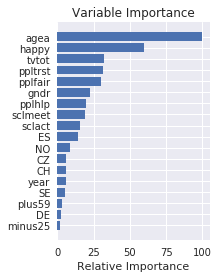

In [5]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

#### Start with the RandomizedSearchCV to randomly search for valid Gradient Boost parameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Create a random parameter grid
random_grid = {'n_estimators': [10,100],
          'max_depth': [5,10],
         'criterion': ('friedman_mse','mae'),
          'subsample': [1.0,.9]
         }

# Use the random grid to search for best hyperparameters
gbc = ensemble.GradientBoostingClassifier()

# Random search of parameters, using 2 fold cross validation, 
# search across 16 different combinations, and use all available cores
rsCV_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid,
                                n_iter = 16, cv = 2, verbose=2, n_jobs = -1)

# Fit the random search model
rsCV_random.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] subsample=1.0, n_estimators=10, max_depth=5, criterion=friedman_mse 
[CV] subsample=1.0, n_estimators=10, max_depth=5, criterion=friedman_mse 
[CV] subsample=0.9, n_estimators=10, max_depth=5, criterion=friedman_mse 
[CV] subsample=0.9, n_estimators=10, max_depth=5, criterion=friedman_mse 
[CV] subsample=1.0, n_estimators=100, max_depth=5, criterion=friedman_mse 
[CV] subsample=1.0, n_estimators=100, max_depth=5, criterion=friedman_mse 
[CV] subsample=0.9, n_estimators=100, max_depth=5, criterion=friedman_mse 
[CV] subsample=0.9, n_estimators=100, max_depth=5, criterion=friedman_mse 
[CV]  subsample=1.0, n_estimators=10, max_depth=5, criterion=friedman_mse, total=   0.1s
[CV]  subsample=0.9, n_estimators=10, max_depth=5, criterion=friedman_mse, total=   0.1s
[CV] subsample=1.0, n_estimators=10, max_depth=10, criterion=friedman_mse 
[CV]  subsample=0.9, n_estimators=10, max_depth=5, criterion=friedman_mse, total=   0.1s
[

In [7]:
# View the best estimator found with RandomSearchCV
rsCV_random.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [ ]:
# Fit and predict with the best parameters:
clf = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

clf.fit(X_train, y_train)

In [33]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.019230769230769232
Percent Type II errors: 0.2118112384069831

Test set accuracy:
Percent Type I errors: 0.044171779141104296
Percent Type II errors: 0.2282208588957055


### Results:

- The exponential loss function performed poorly (with a decrease in two to three score points) and was removed from the GridSearchCV parameters.

- Two variables were created - "Plus59" for people sixty years and older, and "minus25" for people younger than 25. Neither variables had relevant impact on predictions.

- Type I errors improved from .047 to .019 on training and from .063 to .044 on test data.

- Type II errors were worse in the second attempt: from 0.18 to .21 on training and from 0.19 to .23 on test data.